Found 20000 files belonging to 2 classes.
Using 10000 files for training.
Found 20000 files belonging to 2 classes.
Using 10000 files for validation.
Found 5000 files.
Phase 1: Training with frozen base model...
Epoch 1/15


I0000 00:00:1746762621.501770      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9265 - auc: 0.9759 - loss: 0.1980 - precision: 0.9263 - recall: 0.9289
Epoch 1: val_accuracy improved from -inf to 0.98640, saving model to best_dog_cat_model_resnet.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 126ms/step - accuracy: 0.9265 - auc: 0.9759 - loss: 0.1979 - precision: 0.9263 - recall: 0.9289 - val_accuracy: 0.9864 - val_auc: 0.9983 - val_loss: 0.0398 - val_precision: 0.9834 - val_recall: 0.9894
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9515 - auc: 0.9901 - loss: 0.1224 - precision: 0.9510 - recall: 0.9534
Epoch 2: val_accuracy did not improve from 0.98640
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.9515 - auc: 0.9901 - loss: 0.1224 - precision: 0.9510 - recall: 0.9534 - val_accuracy: 0.9856 - val_auc: 0.9989 - val_loss: 0.0382 - val_precision: 0.9809 - val_recall: 0.9904
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9612 - auc: 0.9932 - loss: 0.1007 - precision: 0

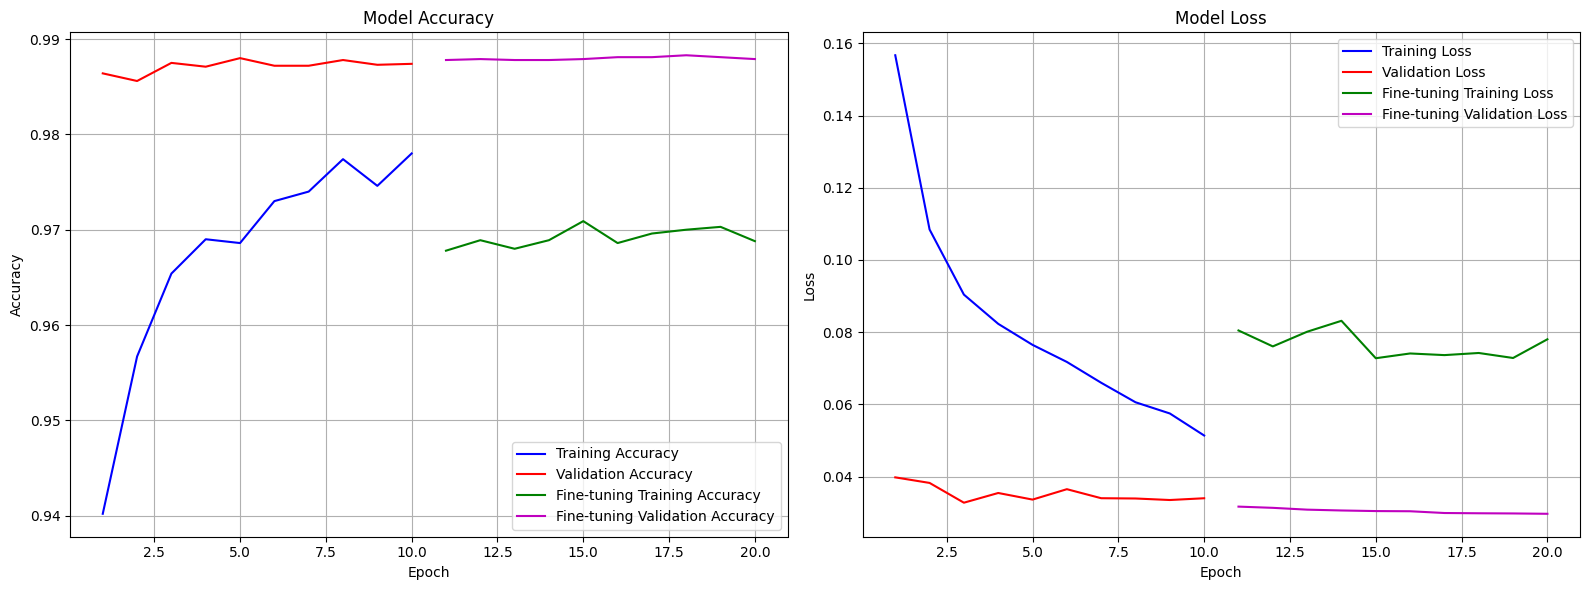

Saved artifact at '/tmp/tmpqm7ddzba'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_372')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138498670822032: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138499236089680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939066832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939067216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939066448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939065680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939067024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939070288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939071440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138498939071824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

W0000 00:00:1746764084.262567      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746764084.262619      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1746764084.419463      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Model training complete and model saved!


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, Normalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50

import matplotlib.pyplot as plt

train_data = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/dogs-vs-cats/train',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.5,
    subset='training',
    verbose=True,
)

val_data = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/dogs-vs-cats/train',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.5,
    subset='validation',
    verbose=True,
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/dogs-vs-cats/test',
    labels=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(256, 256),
    shuffle=False,
    verbose=True,
)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False

    inputs = Input(shape=(256, 256, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.base_model = base_model
    return model

model = build_model()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=train_data.cardinality().numpy() // 2,
    decay_rate=0.9,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_dog_cat_model_resnet.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("Phase 1: Training with frozen base model...")
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2: Fine-tuning the model...")
base_model = model.base_model
base_model.trainable = True

for layer in base_model.layers[:250]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

val_results = model.evaluate(val_data, verbose=1)
print(f"Final Validation Loss: {val_results[0]:.4f}")
print(f"Final Validation Accuracy: {val_results[1]:.4f}")
print(f"Final Validation AUC: {val_results[2]:.4f}")
print(f"Final Validation Precision: {val_results[3]:.4f}")
print(f"Final Validation Recall: {val_results[4]:.4f}")

def plot_training_history(history, fine_tune_history=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    epochs_initial = range(1, len(history.history['accuracy']) + 1)
    ax1.plot(epochs_initial, history.history['accuracy'], 'b-', label='Training Accuracy')
    ax1.plot(epochs_initial, history.history['val_accuracy'], 'r-', label='Validation Accuracy')

    if fine_tune_history:
        epochs_fine = range(len(history.history['accuracy']) + 1,
                          len(history.history['accuracy']) + len(fine_tune_history.history['accuracy']) + 1)
        ax1.plot(epochs_fine, fine_tune_history.history['accuracy'], 'g-', label='Fine-tuning Training Accuracy')
        ax1.plot(epochs_fine, fine_tune_history.history['val_accuracy'], 'm-', label='Fine-tuning Validation Accuracy')

    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs_initial, history.history['loss'], 'b-', label='Training Loss')
    ax2.plot(epochs_initial, history.history['val_loss'], 'r-', label='Validation Loss')

    if fine_tune_history:
        epochs_fine = range(len(history.history['loss']) + 1,
                          len(history.history['loss']) + len(fine_tune_history.history['loss']) + 1)
        ax2.plot(epochs_fine, fine_tune_history.history['loss'], 'g-', label='Fine-tuning Training Loss')
        ax2.plot(epochs_fine, fine_tune_history.history['val_loss'], 'm-', label='Fine-tuning Validation Loss')

    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history, fine_tune_history)

model.save('complete_dog_cat.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('dog_cat_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model training complete and model saved!")

def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    predictions = model.predict(img_array)
    score = predictions[0][0]

    if score > 0.5:
        return f"Dog ({score:.2f})"
    else:
        return f"Cat ({1-score:.2f})"

In [3]:
import os
import random

test_dir = '/kaggle/input/dogs-vs-cats/test'

cat_dir = os.path.join(test_dir, 'cats')
dog_dir = os.path.join(test_dir, 'dogs')

cat_files = [os.path.join('cats', fname) for fname in os.listdir(cat_dir)
             if fname.endswith('.jpg') and '.' in fname]
dog_files = [os.path.join('dogs', fname) for fname in os.listdir(dog_dir)
             if fname.endswith('.jpg') and '.' in fname]

# Randomly sample 50 from each (set seed for reproducibility if you like)
random.seed(42)
cat_files_sample = random.sample(cat_files, 50)
dog_files_sample = random.sample(dog_files, 50)

test_filenames = cat_files_sample + dog_files_sample
random.shuffle(test_filenames) 



In [4]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('best_dog_cat_model_resnet.keras')

results = []
for rel_path in test_filenames:
    img_path = os.path.join(test_dir, rel_path)
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
 

    pred = model.predict(img_array, verbose=0)[0][0]
    label_str = 'dog' if pred > 0.5 else 'cat'
    filename = os.path.basename(rel_path)  # <--- use the original file name
    results.append({'filename': filename, 'prediction': label_str})

print(results[:5])

submission = pd.DataFrame(results)
submission.to_csv('submission.csv', index=False)
print(submission.head())

[{'filename': 'cat.9958.jpg', 'prediction': 'cat'}, {'filename': 'cat.3800.jpg', 'prediction': 'cat'}, {'filename': 'dog.8884.jpg', 'prediction': 'dog'}, {'filename': 'dog.1081.jpg', 'prediction': 'dog'}, {'filename': 'cat.9783.jpg', 'prediction': 'cat'}]
       filename prediction
0  cat.9958.jpg        cat
1  cat.3800.jpg        cat
2  dog.8884.jpg        dog
3  dog.1081.jpg        dog
4  cat.9783.jpg        cat
